In [6]:
## import libraries

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif, GenericUnivariateSelect, RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import regex as re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
'''
Name: feature_selection_galore

Purpose: Create a dataframe displaying results for top N features picked by 9 different feature selection methods

Input: Features, outcomes, number of features to be selected

Output: A dataframe displaying results for top N features picked by 9 different feature selection methods
'''

def feature_selection_galore(X, y,num_feats):
    
    ## Perform StandardScaler on feature for the selection methods that require it
    scaler = StandardScaler()
    scaler.fit(X)
    X_norm = scaler.transform(X)
    
    ### SPEARMAN CORRELATION ###
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    ### CHI SQUARED ###
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    
    
    ### ANOVA ###
    anova_selector = SelectKBest(k=num_feats)
    anova_selector.fit(X, y)
    anova_support = anova_selector.get_support()
    anova_feature = X.loc[:,anova_support].columns.tolist()
    
    ### MUTUAL INFO ###
    mutual_info_selector = SelectKBest(mutual_info_classif, k=num_feats)
    mutual_info_selector.fit(X, y)
    mutual_info_support = mutual_info_selector.get_support()
    mutual_info_feature = X.loc[:,mutual_info_support].columns.tolist()
    
    ### LOGISTIC REGRESSION ###
    rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    rfe_selector = RFECV(estimator=LogisticRegression(max_iter=10000000, random_state=42), cv=rkf, min_features_to_select=num_feats, verbose=5, n_jobs=-1)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    
    ### LASSO REGRESSION ###
    embeded_lr_selector = RFECV(estimator=Lasso(max_iter=10000000, random_state=42), cv=rkf, min_features_to_select=num_feats, verbose=5, n_jobs=-1)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    
    ### RANDOM FOREST ###
    embeded_rf_selector = RFECV(estimator=RandomForestClassifier(random_state=42), cv=rkf, min_features_to_select=num_feats, verbose=5, n_jobs=-1)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    
    ### LINEAR SVC ###
    model_svc = LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=10000000, random_state=42)
    embeded_svc_selector = RFECV(estimator=model_svc, cv=rkf, min_features_to_select=num_feats, verbose=5, n_jobs=-1)
    embeded_svc_selector.fit(X_norm, y)
    embeded_svc_support = embeded_svc_selector.get_support()
    embeded_svc_feature = X.loc[:,embeded_svc_support].columns.tolist()
    
    ### LGBM ###
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, random_state=42)
    embeded_lgb_selector = RFECV(estimator=lgbc, cv=rkf, min_features_to_select=num_feats, verbose=5, step=1, n_jobs=-1)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    
    
    ### MAKE FINAL DATAFRAME
    feature_selection_df = pd.DataFrame({'Feature':X.columns, 'Pearson':cor_support, 'Chi-2':chi_support, "ANOVA":anova_support, "mutual_info":mutual_info_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, "Linear SVC":embeded_svc_support, 'LightGBM':embeded_lgb_support})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    
    return feature_selection_df
    

In [8]:
## Import train data
name = "../data/train_70_30.csv"
df = pd.read_csv(name)

In [9]:
## Separate into features and outcome
X = df.drop(['outcome'], axis=1, inplace=False)
y = df["outcome"]

In [10]:
## Create dataframe with the number of tests each feature passes
df_features = feature_selection_galore(X, y, 25)

C:\Users\Bernardo\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Bernardo\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Bernardo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [138] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\Bernardo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
F

Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 fe

Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator wi

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 fe

In [11]:
## Look at the fisrt 50 features, pick all the ones that passed more than half the tests 5/9.
df_features.head(50)

,Feature,Pearson,Chi-2,ANOVA,mutual_info,RFE,Logistics,Random Forest,Linear SVC,LightGBM,Total
1,CSSA1.TOTAL,True,True,True,True,True,True,True,True,True,9
2,SA_DIC_LG,True,False,True,True,True,True,True,True,True,8
3,EA,True,True,True,False,True,True,True,True,True,8
4,CTQ,True,True,True,True,False,True,True,True,True,8
5,EN,True,True,True,False,False,True,True,True,True,7
6,SA_SCR,True,False,True,False,False,True,True,True,True,6
7,SA,True,False,True,False,False,True,True,True,True,6
8,PA,True,False,True,False,False,True,True,True,True,6
9,P13_B,True,False,True,False,False,True,True,True,True,6
10,EA_SCR,True,False,True,False,False,True,True,True,True,6


In [12]:
## Print the features in order of score
ordered_features = df_features["Feature"].to_list()
print(ordered_features)

['CSSA1.TOTAL', 'SA_DIC_LG', 'EA', 'CTQ', 'EN', 'SA_SCR', 'SA', 'PA', 'P13_B', 'EA_SCR', 'EA_DIC_LG', 'EA_DIC_HRD', 'T_S4', 'P8_A', 'P17_A', 'P16_B', 'D25C', 'D12_perWeek', 'PN', 'P18', 'P16_A', 'P15_B', 'P15_A', 'P14_A', 'M28_A', 'D43', 'D38_perWeek', 'D10', 'T_S6', 'T_S1', 'SA_DIC_HRD', 'P14_B', 'M2_Yes', 'M27_A', 'L30_D', 'F4_C', 'F29', 'F26', 'F23', 'E20_adj', 'D45', 'D33TabacoD', 'D27C', 'D26', 'T_S9', 'T_S2', 'P3_B', 'P13_A', 'P12_A', 'P10_B', 'L29_E', 'L29_C', 'L17_A', 'H8_A', 'H6_A', 'H11_4', 'H11_2', 'F9_B', 'F4_A', 'F44', 'F19', 'E29_B_adj', 'E24', 'D39', 'D28', 'D21', 'D19', 'D16', 'D13', 'D07_Yrs', 'D06A', 'D05A', 'D04A', 'T_S8', 'T_S7', 'T_S5', 'T_S3', 'P9_B', 'P9_A', 'P8_B', 'P5_B', 'P4', 'P2', 'P12_B', 'P11_B', 'P11_A', 'P10_A', 'P1', 'M9_Composite', 'M7', 'M3to15_NumbChronicDisease', 'M3', 'M26_A', 'M25', 'M21', 'M20', 'M16', 'M15', 'L9_B', 'L6', 'L4', 'L32_B', 'L30_C', 'L29_B', 'L28_D', 'L28_C', 'L2', 'L16', 'L14_A', 'L1', 'H9_A', 'H7_A', 'H3_A', 'H2_A', 'H1_A', 'H13_A

In [14]:
## Make new Dataframe only including features that passed at least 5 tests
df_2 = df[['CSSA1.TOTAL', 'SA_DIC_LG', 'EA', 'CTQ', 'EN', 'SA_SCR', 'SA', 'PA', 'P13_B', 
           'EA_SCR', 'EA_DIC_LG', 'EA_DIC_HRD', 'T_S4', 'P8_A', 'P17_A', 'P16_B', 'D25C', 'D12_perWeek', 'outcome']]

In [15]:
## Check shape of dataframe
df_2.shape

(192, 19)

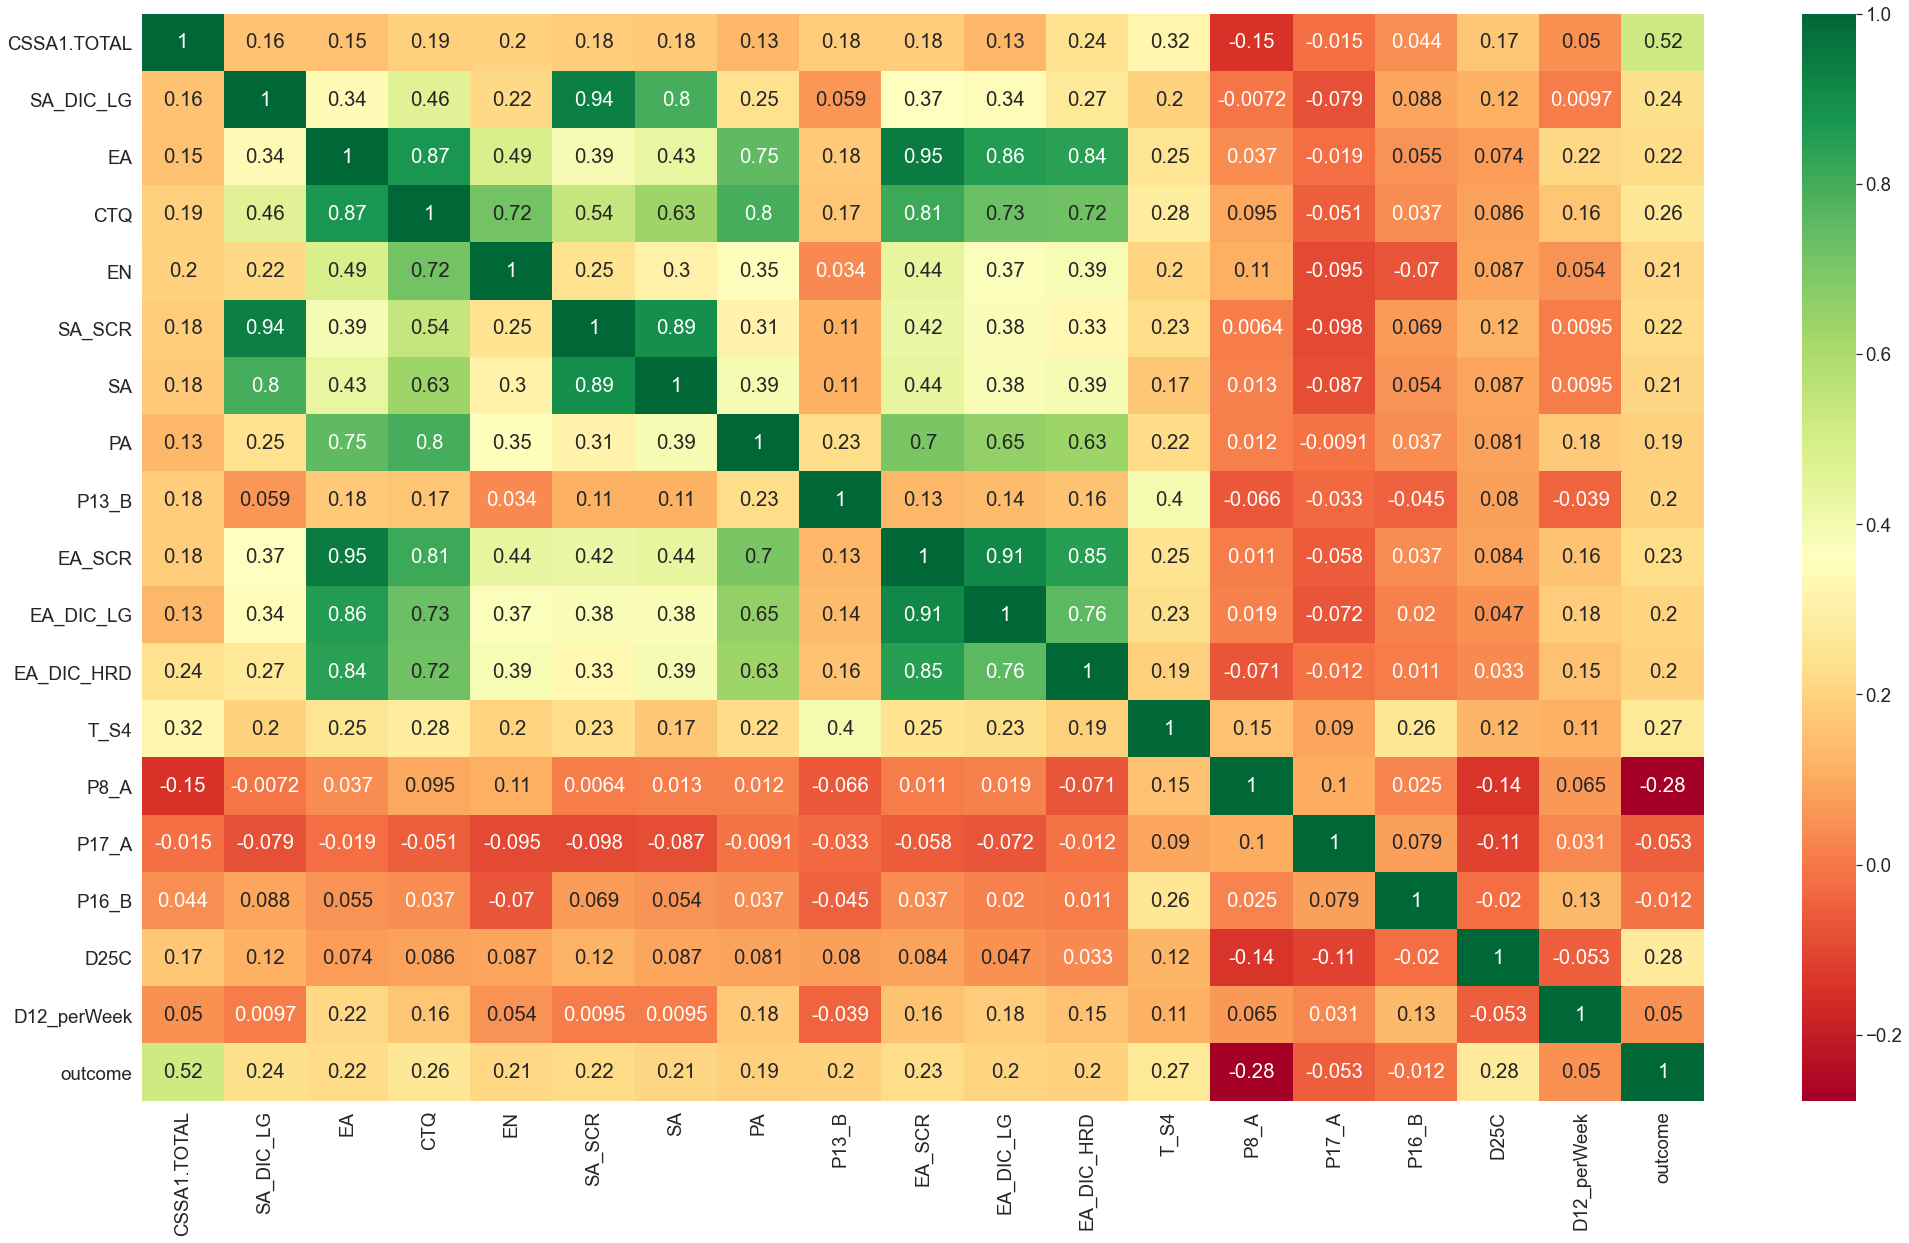

In [16]:
## Make correlation heatmap for features
corrmat = df_2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(35,20))
sns.set(font_scale = 1.7)

#plot heat map and save it
sns.heatmap(df_2[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('../figures/2022_01_25_heatmap_raw_70_30.png', dpi=1200, transparent=True, bbox_inches="tight")

In [20]:
## Make new Dataframe only including features that are not contained in other features.
## Some variables are subscales of other variables, must make sure we don't
## Have redundant data.
df_3 = df[['CSSA1.TOTAL', 'EA', 'EN', 'SA', 'PA', 'P13_B',
           'T_S4', 'P8_A', 'P16_B', 'D25C', 'D12_perWeek', 'outcome']]

In [21]:
## Rename features so they have intelligible names.
df_3.columns = ["CSSA Score Week 1", "Childhood Emotional Abuse",
                "Childhood Emotional Neglect", "Childhood Sexual Abuse", "Childhood Physical Abuse",
                "Impulsivity (Last 30 Days)", "Psychiatric Problems", "Sleep Problems (Lifetime)", 
                "Suicide Attempts (Last 30 Days)", "Used Cannabis More than 50 Days", "Alcohol Use Frequency (Per Week)",
                "outcome"]

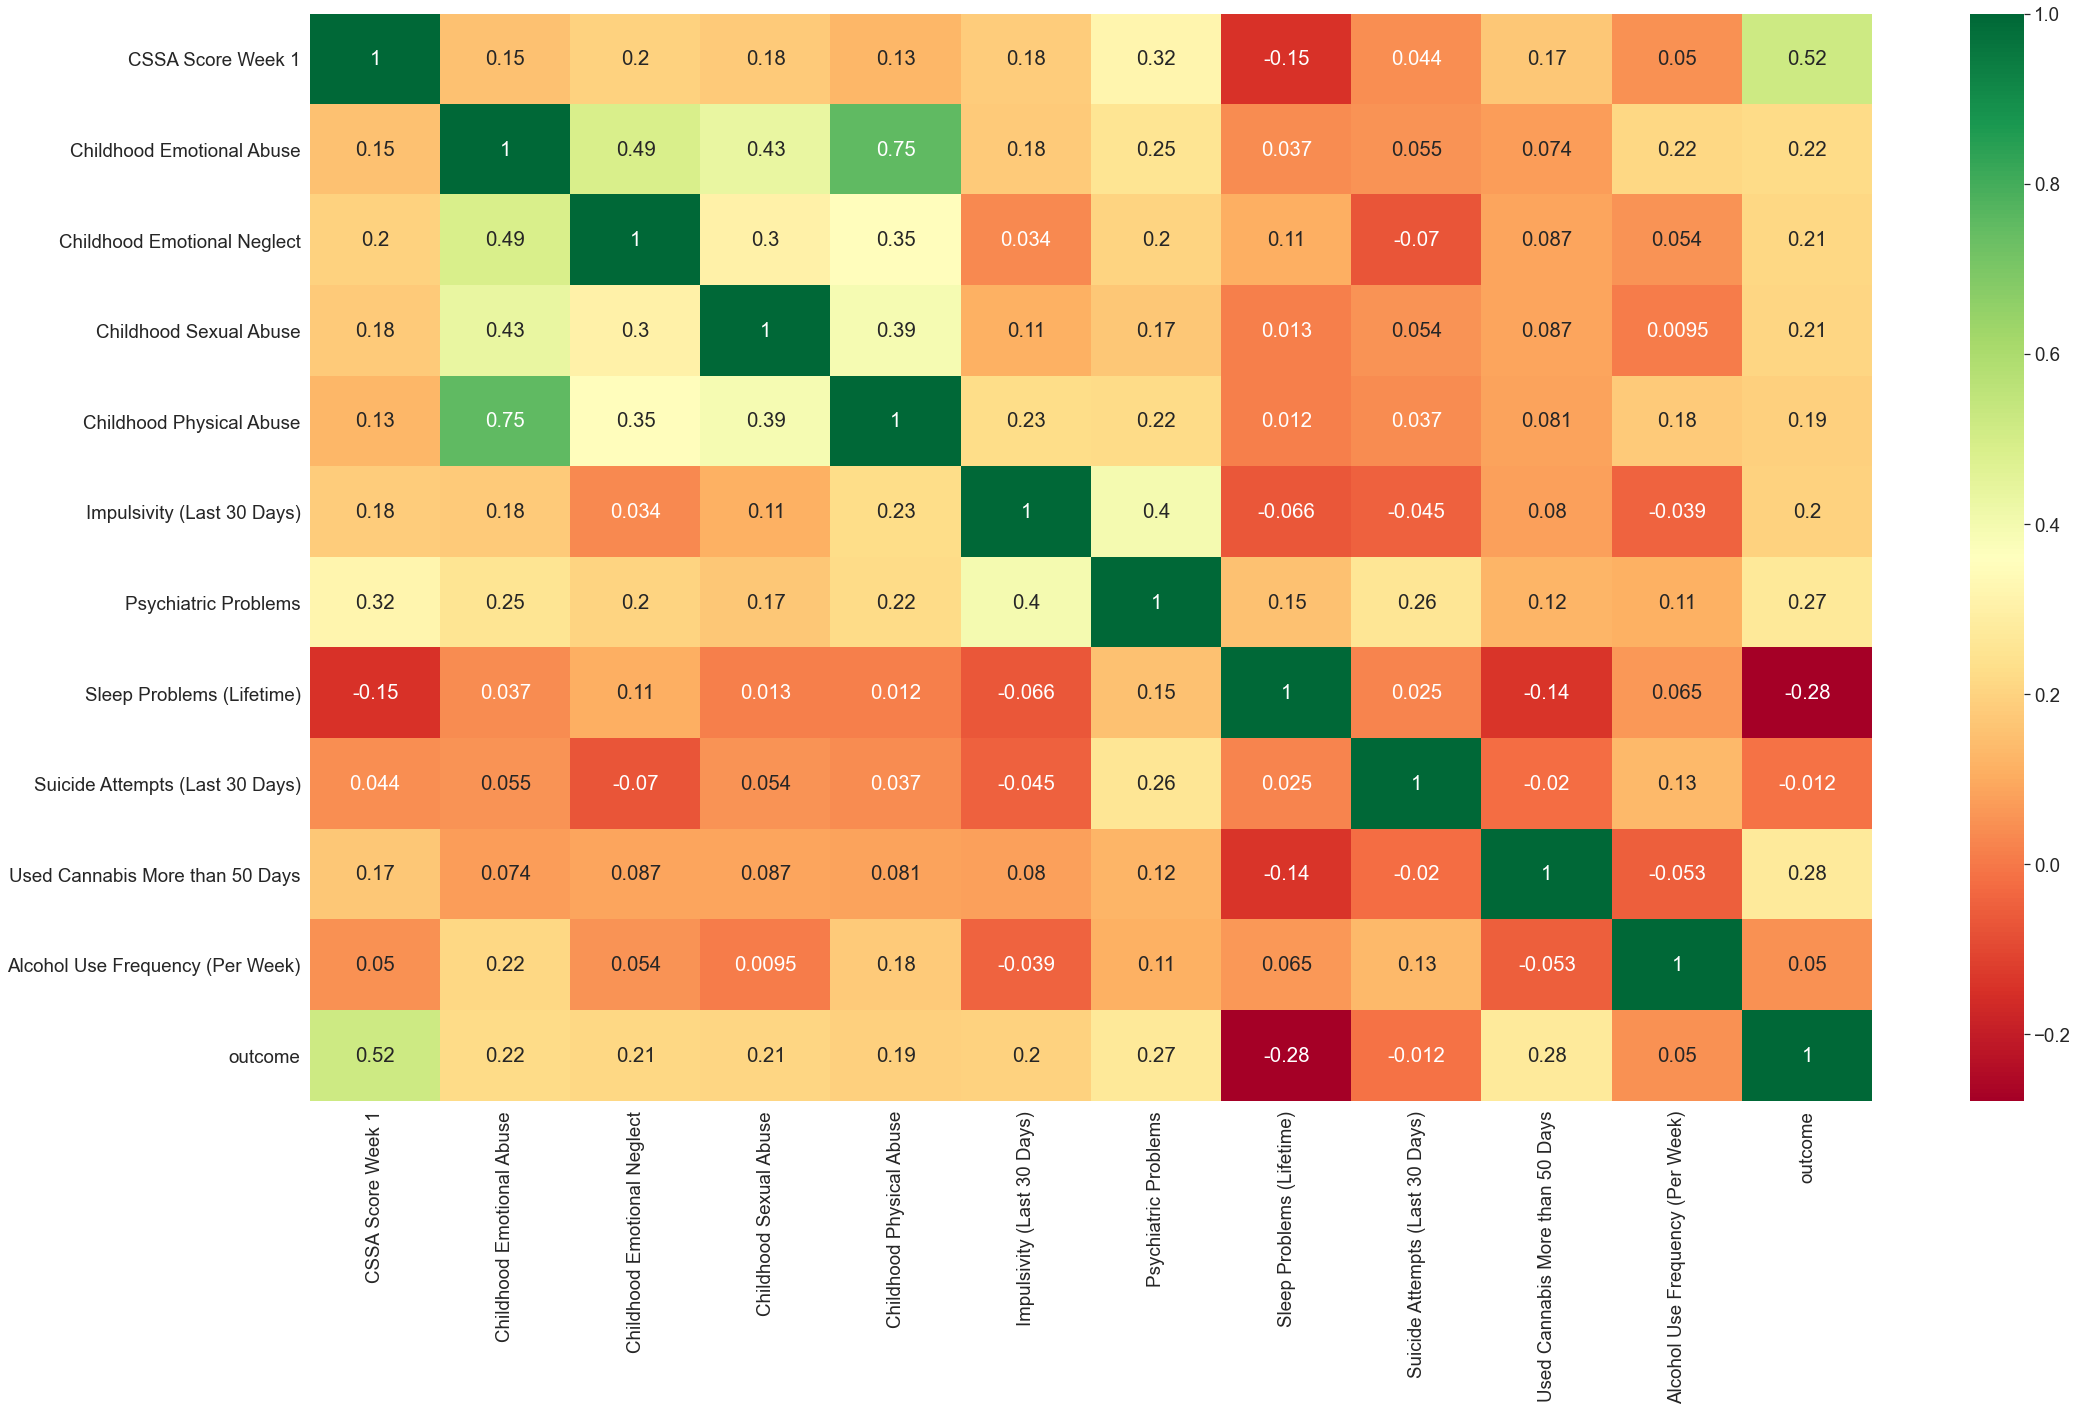

In [23]:
## Remake heatmap with cleaned up features
corrmat = df_3.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(35,20))
sns.set(font_scale = 1.7)

#plot heat map and save it
sns.heatmap(df_3[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('../figures/2022_01_25_heatmap_filtered_70_30.png', dpi=1200, transparent=True, bbox_inches="tight")

In [24]:
## Save training dataset with selected features
df_3.to_csv("../data/feature_selected_train_dataset_70_30.csv", index=False)

In [25]:
## Save matrix with feature selection test results
df_features.to_csv("../data/selected_feature_matrix_70_30.csv", index=True)

In [26]:
## Load train dataset for 70_30. Only keep selected features and save it.
name = "../data/train_70_30.csv"
df_70_30_train = pd.read_csv(name)

df_70_30_train = df_70_30_train[['CSSA1.TOTAL', 'EA', 'EN', 'SA', 'PA', 'P13_B',
           'T_S4', 'P8_A', 'P16_B', 'D25C', 'D12_perWeek', 'outcome']]

df_70_30_train.columns =  ["CSSA Score Week 1", "Childhood Emotional Abuse",
                "Childhood Emotional Neglect", "Childhood Sexual Abuse", "Childhood Physical Abuse",
                "Impulsivity (Last 30 Days)", "Psychiatric Problems", "Sleep Problems (Lifetime)", 
                "Suicide Attempts (Last 30 Days)", "Used Cannabis More than 50 Days", "Alcohol Use Frequency (Per Week)",
                "outcome"]


df_70_30_train.to_csv("../data/feature_selected_train_dataset_70_30.csv", index=False)

In [27]:
## Load test dataset for 70_30. Only keep selected features and save it.
name = "../data/test_70_30.csv"
df_70_30_test = pd.read_csv(name)

df_70_30_test = df_70_30_test[['CSSA1.TOTAL', 'EA', 'EN', 'SA', 'PA', 'P13_B',
           'T_S4', 'P8_A', 'P16_B', 'D25C', 'D12_perWeek', 'outcome']]

df_70_30_test.columns = ["CSSA Score Week 1", "Childhood Emotional Abuse",
                "Childhood Emotional Neglect", "Childhood Sexual Abuse", "Childhood Physical Abuse",
                "Impulsivity (Last 30 Days)", "Psychiatric Problems", "Sleep Problems (Lifetime)", 
                "Suicide Attempts (Last 30 Days)", "Used Cannabis More than 50 Days", "Alcohol Use Frequency (Per Week)",
                "outcome"]


df_70_30_test.to_csv("../data/feature_selected_test_dataset_70_30.csv", index=False)